In [1]:
# Cell 1: Import necessary libraries and mount Google Drive
import os
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, DenseNet121
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Cell 2: Set up paths and parameters
import os
import numpy as np
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, DenseNet121
from tensorflow.keras import layers, Model
import pandas as pd
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

DATASET_PATH = '/content/drive/MyDrive/Dataset/HAM10000_images_part_2'
METADATA_PATH = '/content/drive/MyDrive/Dataset/HAM10000_metadata.csv'
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 7  # HAM10000 has 7 classes

# Load metadata
metadata = pd.read_csv(METADATA_PATH)

# Map class names to numeric labels
class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_map = {name: idx for idx, name in enumerate(class_names)}

# Create image paths and labels
image_paths = []
labels = []

for index, row in metadata.iterrows():
    image_id = row['image_id']  # e.g., ISIC_0024306
    label = row['dx'].upper()   # Convert to uppercase to match class_names
    if label in label_map:
        image_path = os.path.join(DATASET_PATH, f"{image_id}.jpg")
        if os.path.exists(image_path):
            image_paths.append(image_path)
            labels.append(label_map[label])

print(f"Number of valid images: {len(image_paths)}")
print(f"Unique labels: {len(set(labels))}")  # Should be 7
print(f"Class distribution: {pd.Series(labels).value_counts()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of valid images: 5015
Unique labels: 7
Class distribution: 1    3274
0     678
4     535
2     248
3     144
6      77
5      59
Name: count, dtype: int64


In [3]:
# Cell 3: Split the dataset
# First split: 70% train, 30% remaining
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, train_size=0.7, random_state=42, stratify=labels
)

# Second split: 10% validation, 20% test from remaining 30%
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.6667, random_state=42, stratify=temp_labels
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

Training samples: 3510
Validation samples: 501
Test samples: 1004


In [4]:
# Cell 4: Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Function to create generator from paths and labels
def create_generator(paths, labels, datagen, shuffle=True):
    data = pd.DataFrame({
        'filename': paths,
        'class': [str(label) for label in labels]  # Numeric labels as strings
    })
    return datagen.flow_from_dataframe(
        dataframe=data,
        x_col='filename',
        y_col='class',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=shuffle,
        classes=[str(i) for i in range(NUM_CLASSES)]  # Enforce 7 classes
    )

train_generator = create_generator(train_paths, train_labels, train_datagen)
val_generator = create_generator(val_paths, val_labels, val_datagen, shuffle=False)
test_generator = create_generator(test_paths, test_labels, test_datagen, shuffle=False)

# Verify generator output
x, y = next(train_generator)
print(f"Input batch shape: {x.shape}")  # Should be (16, 224, 224, 3)
print(f"Output labels shape: {y.shape}")  # Should be (16, 7)

Found 3510 validated image filenames belonging to 7 classes.
Found 501 validated image filenames belonging to 7 classes.
Found 1004 validated image filenames belonging to 7 classes.
Input batch shape: (16, 224, 224, 3)
Output labels shape: (16, 7)


In [5]:
# Cell 5: Define the ensemble model
def create_ensemble_model():
    # Load pretrained models
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base models
    for model in [resnet, vgg, densenet]:
        model.trainable = False

    # Add custom layers
    inputs = layers.Input(shape=(224, 224, 3))

    # Get features from each model
    resnet_features = resnet(inputs)
    vgg_features = vgg(inputs)
    densenet_features = densenet(inputs)

    # Global pooling
    resnet_pool = layers.GlobalAveragePooling2D()(resnet_features)
    vgg_pool = layers.GlobalAveragePooling2D()(vgg_features)
    densenet_pool = layers.GlobalAveragePooling2D()(densenet_features)

    # Concatenate features
    concatenated = layers.Concatenate()([resnet_pool, vgg_pool, densenet_pool])

    # Add dense layers
    x = layers.Dense(512, activation='relu')(concatenated)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return Model(inputs, outputs)

model = create_ensemble_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Cell 6: Train the model
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]

try:
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=10,
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=callbacks,
        verbose=1
    )
except Exception as e:
    print(f"Training failed with error: {str(e)}")
    raise

model.save('/content/drive/MyDrive/ham10000_ensemble_model.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1276s 6s/step - accuracy: 0.6130 - loss: 1.3480 - precision: 0.6755 - recall: 0.5438 - val_accuracy: 0.6707 - val_loss: 0.9381 - val_precision: 0.7898 - val_recall: 0.5848 - learning_rate: 0.0010
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 91s 412ms/step - accuracy: 0.6776 - loss: 0.9263 - precision: 0.8031 - recall: 0.5776 - val_accuracy: 0.6786 - val_loss: 0.8855 - val_precision: 0.7677 - val_recall: 0.6068 - learning_rate: 0.0010
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 141s 409ms/step - accuracy: 0.6663 - loss: 0.9094 - precision: 0.8112 - recall: 0.5591 - val_accuracy: 0.6846 - val_loss: 0.9192 - val_precision: 0.7868 - val_recall: 0.5968 - learning_rate: 0.0010
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 90s 407ms/step - accuracy: 0.6823 - loss: 0.8763 - precision: 0.8334 - recall: 0.5825 - val_accuracy: 0.6806 - val_loss: 0.8866 - val_precision: 0.7850 - val_recall: 0.6048 - learning_rate: 0.0010
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 143s 413ms/s

63/63 ━━━━━━━━━━━━━━━━━━━━ 323s 5s/step


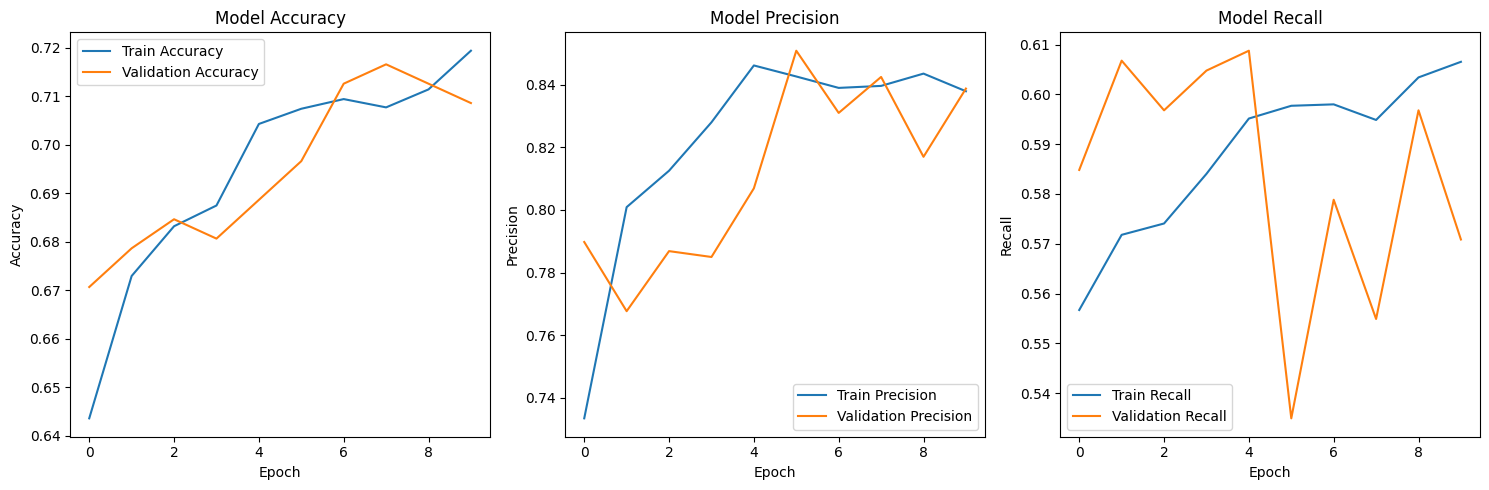


Test Accuracy: 0.7261
Test Precision: 0.7000
Test Recall: 0.7261


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
# Cell 7: Evaluate and plot results
# Get predictions on test set
test_pred = model.predict(test_generator)
test_pred_classes = np.argmax(test_pred, axis=1)
test_true_classes = test_generator.classes

# Calculate metrics
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_prec = history.history['precision']
val_prec = history.history['val_precision']
train_rec = history.history['recall']
val_rec = history.history['val_recall']

# Plot metrics
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Precision plot
plt.subplot(1, 3, 2)
plt.plot(train_prec, label='Train Precision')
plt.plot(val_prec, label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Recall plot
plt.subplot(1, 3, 3)
plt.plot(train_rec, label='Train Recall')
plt.plot(val_rec, label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# Print final test metrics
test_acc = accuracy_score(test_true_classes, test_pred_classes)
test_prec = precision_score(test_true_classes, test_pred_classes, average='weighted')
test_rec = recall_score(test_true_classes, test_pred_classes, average='weighted')

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")